In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
# Initialising dfs
data_path = r'C:\Users\aaani\OneDrive - Birmingham City University\Postgrad\Dissertation\Data'
admissions = pd.read_csv(f'{data_path}/admissions.csv.gz')
patients = pd.read_csv(f'{data_path}/patients.csv.gz')
diagnoses = pd.read_csv(f'{data_path}/diagnoses_icd.csv.gz')
#lab = pd.read_csv(f'{data_path}/labevents.csv.gz')
icu = pd.read_csv(f'{data_path}/icustays.csv.gz') 

In [3]:
patients.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000058,F,33,2168,2020 - 2022,NaN
3,10000068,F,19,2160,2008 - 2010,NaN
4,10000084,M,72,2160,2017 - 2019,2161-02-13


In [ ]:
# merged patients to multiple links patient to their diagnoses, lab results, and ICU stays
merged = pd.merge(admissions, patients, on='subject_id', how='inner')
merged = pd.merge(merged, diagnoses, on= ['subject_id' , 'hadm_id'], how='inner')
#merged = pd.merge(merged, lab, on=['subject_id' , 'hadm_id'], how='inner')

merged

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,edouttime,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod,seq_num,icd_code,icd_version
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,...,2180-05-06 23:30:00,0,F,52,2180,2014 - 2016,2180-09-09,1,5723,9
1,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,...,2180-05-06 23:30:00,0,F,52,2180,2014 - 2016,2180-09-09,2,78959,9
2,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,...,2180-05-06 23:30:00,0,F,52,2180,2014 - 2016,2180-09-09,3,5715,9
3,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,...,2180-05-06 23:30:00,0,F,52,2180,2014 - 2016,2180-09-09,4,07070,9
4,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,...,2180-05-06 23:30:00,0,F,52,2180,2014 - 2016,2180-09-09,5,496,9


In [15]:
# admittime is a datetime object
merged['admittime'] = pd.to_datetime(merged['admittime'])

# For each patient, find the year of their first shifted admission
first_admission_year_shifted = merged.groupby('subject_id')['admittime'].min().dt.year

# Map the earliest shifted year back to every admission for each patient
merged['first_admission_year_shifted'] = merged['subject_id'].map(first_admission_year_shifted)

# Calculate the unique date shift for each patient
merged['date_shift'] = merged['first_admission_year_shifted'] - merged['anchor_year']

# Create true_admission_year column by subtracting the shift
merged['true_admission_year'] = merged['admittime'].dt.year - merged['date_shift']

merged['age_at_admission'] = merged['anchor_age'] + (merged['true_admission_year'] - merged['anchor_year'])

merged.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,anchor_year,anchor_year_group,dod,seq_num,icd_code,icd_version,first_admission_year_shifted,date_shift,true_admission_year,age_at_admission
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,...,2180,2014 - 2016,2180-09-09,1,5723,9,2180,0,2180,52
1,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,...,2180,2014 - 2016,2180-09-09,2,78959,9,2180,0,2180,52
2,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,...,2180,2014 - 2016,2180-09-09,3,5715,9,2180,0,2180,52
3,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,...,2180,2014 - 2016,2180-09-09,4,07070,9,2180,0,2180,52
4,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,...,2180,2014 - 2016,2180-09-09,5,496,9,2180,0,2180,52


In [ ]:
# creating a dataset that removes duplicate patients, for analysis
unique = merged.drop_duplicates(subset=['subject_id'])


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,anchor_year,anchor_year_group,dod,seq_num,icd_code,icd_version,first_admission_year_shifted,date_shift,true_admission_year,age_at_admission
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,...,2180,2014 - 2016,2180-09-09,1,5723,9,2180,0,2180,52
39,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P39NWO,EMERGENCY ROOM,NaN,NaN,...,2160,2008 - 2010,NaN,1,30500,9,2160,0,2160,19
40,10000084,23052089,2160-11-21 01:56:00,2160-11-25 14:52:00,NaN,EW EMER.,P42H7G,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Medicare,...,2160,2017 - 2019,2161-02-13,1,G3183,10,2160,0,2160,72
52,10000108,27250926,2163-09-27 23:17:00,2163-09-28 09:04:00,NaN,EU OBSERVATION,P40JML,EMERGENCY ROOM,NaN,NaN,...,2163,2014 - 2016,NaN,1,5283,9,2163,0,2163,25
54,10000117,22927623,2181-11-15 02:05:00,2181-11-15 14:52:00,NaN,EU OBSERVATION,P47EY8,EMERGENCY ROOM,NaN,Medicaid,...,2174,2008 - 2010,NaN,1,R1310,10,2181,7,2174,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6364139,19999733,27674281,2152-07-08 23:29:00,2152-07-09 03:45:00,NaN,EU OBSERVATION,P5481E,EMERGENCY ROOM,NaN,Private,...,2152,2011 - 2013,NaN,1,9953,9,2152,0,2152,19
6364142,19999784,21142523,2123-06-16 09:13:00,2123-06-20 15:42:00,NaN,ELECTIVE,P6717A,PHYSICIAN REFERRAL,HOME,Medicaid,...,2119,2017 - 2019,NaN,1,Z5111,10,2119,0,2123,61
6364417,19999828,25744818,2149-01-08 16:44:00,2149-01-18 17:00:00,NaN,EW EMER.,P13JMH,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicaid,...,2147,2017 - 2019,NaN,1,T8141XA,10,2147,0,2149,48
6364458,19999840,21033226,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,EW EMER.,P33612,EMERGENCY ROOM,DIED,Private,...,2164,2008 - 2010,2164-09-17,1,3453,9,2164,0,2164,58


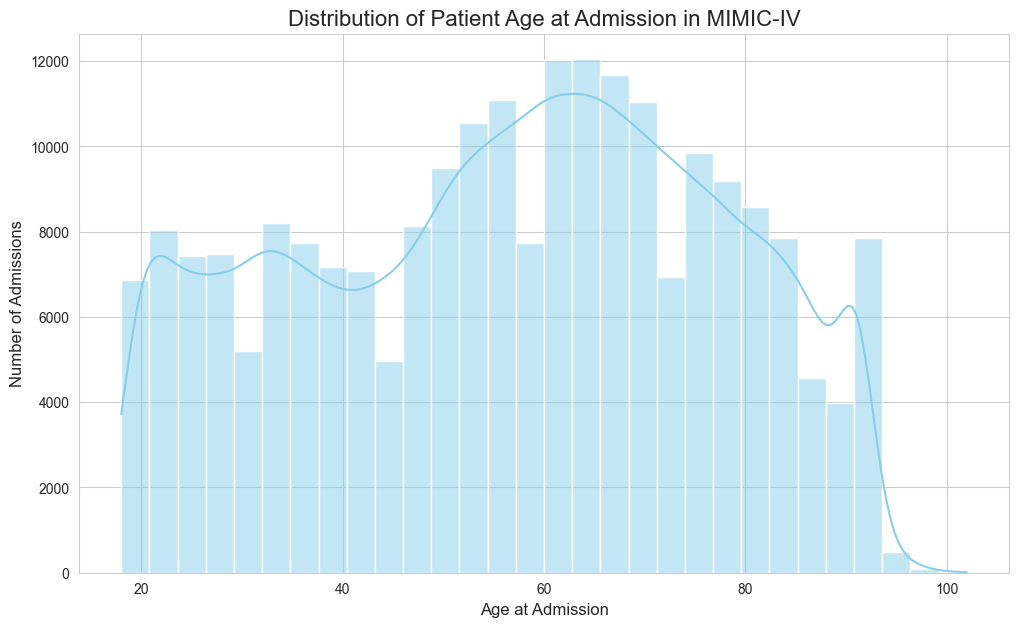

In [17]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

sns.histplot(unique['age_at_admission'], bins=30, kde=True, color='skyblue')


plt.title('Distribution of Patient Age at Admission in MIMIC-IV', fontsize=16)
plt.xlabel('Age at Admission', fontsize=12)
plt.ylabel('Number of Admissions', fontsize=12)

# Saving the plot as an image file 
plt.savefig('age_distribution.png')


In [18]:
# Displaying unique anchor years
unique_anchor_years = unique['anchor_year_group'].unique()
unique_anchor_years.sort()
print("Unique Anchor Years:", unique_anchor_years)

Unique Anchor Years: ['2008 - 2010' '2011 - 2013' '2014 - 2016' '2017 - 2019' '2020 - 2022']


In [19]:
historical_groups = ['2008 - 2010', '2011 - 2013', '2014 - 2016']
contemporary_groups = ['2017 - 2019', '2020 - 2022']

historical = unique[unique['anchor_year_group'].isin(historical_groups)]
contemporary = unique[unique['anchor_year_group'].isin(contemporary_groups)]

historical_age_distribution = historical['age_at_admission'].describe()
contemporary_age_distribution = contemporary['age_at_admission'].describe()

print("Historical Age Distribution:\n", historical_age_distribution)
print("\nContemporary Age Distribution:\n", contemporary_age_distribution)

historical.head() 

Historical Age Distribution:
 count    156659.000000
mean         55.856414
std          20.429776
min          18.000000
25%          39.000000
50%          57.000000
75%          72.000000
max         102.000000
Name: age_at_admission, dtype: float64

Contemporary Age Distribution:
 count    66632.000000
mean        57.603164
std         20.242402
min         18.000000
25%         41.000000
50%         61.000000
75%         73.000000
max         97.000000
Name: age_at_admission, dtype: float64


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,anchor_year,anchor_year_group,dod,seq_num,icd_code,icd_version,first_admission_year_shifted,date_shift,true_admission_year,age_at_admission
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,...,2180,2014 - 2016,2180-09-09,1,5723,9,2180,0,2180,52
39,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P39NWO,EMERGENCY ROOM,NaN,NaN,...,2160,2008 - 2010,NaN,1,30500,9,2160,0,2160,19
52,10000108,27250926,2163-09-27 23:17:00,2163-09-28 09:04:00,NaN,EU OBSERVATION,P40JML,EMERGENCY ROOM,NaN,NaN,...,2163,2014 - 2016,NaN,1,5283,9,2163,0,2163,25
54,10000117,22927623,2181-11-15 02:05:00,2181-11-15 14:52:00,NaN,EU OBSERVATION,P47EY8,EMERGENCY ROOM,NaN,Medicaid,...,2174,2008 - 2010,NaN,1,R1310,10,2181,7,2174,48
78,10000248,20600184,2192-11-30 01:25:00,2192-11-30 19:20:00,NaN,EU OBSERVATION,P416B5,EMERGENCY ROOM,NaN,Private,...,2192,2014 - 2016,NaN,1,9222,9,2192,0,2192,34


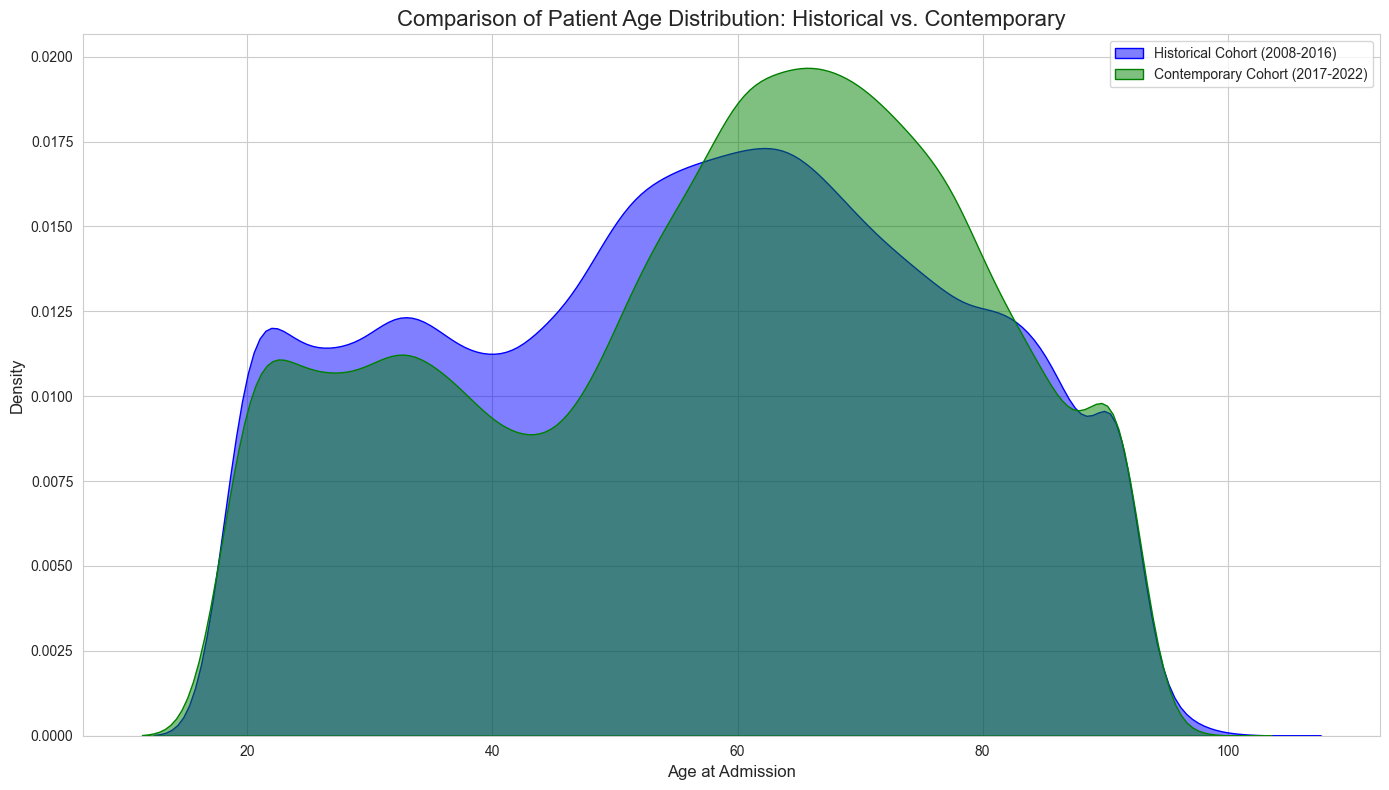

In [20]:
sns.set_style("whitegrid")

# Create a figure for the plot
plt.figure(figsize=(14, 8))

# Plot the distribution of age for the historical cohort
sns.kdeplot(historical['age_at_admission'], label='Historical Cohort (2008-2016)', color='blue', fill=True, alpha=0.5)

# Plot the distribution of age for the contemporary cohort on the same axes
sns.kdeplot(contemporary['age_at_admission'], label='Contemporary Cohort (2017-2022)', color='green', fill=True, alpha=0.5)

# Add titles, labels, and a legend
plt.title('Comparison of Patient Age Distribution: Historical vs. Contemporary', fontsize=16)
plt.xlabel('Age at Admission', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the new plot as an image file
plt.savefig('age_distribution_comparison.png')

#This is important as it provided visual evidence of a data drift


In [ ]:
# count the unique race categories
unique_race = unique['race'].unique()
unique_race.sort()
print("Unique Race Categories:", unique_race)

Unique Race Categories: ['AMERICAN INDIAN/ALASKA NATIVE' 'ASIAN' 'ASIAN - ASIAN INDIAN'
 'ASIAN - CHINESE' 'ASIAN - KOREAN' 'ASIAN - SOUTH EAST ASIAN'
 'BLACK/AFRICAN' 'BLACK/AFRICAN AMERICAN' 'BLACK/CAPE VERDEAN'
 'BLACK/CARIBBEAN ISLAND' 'HISPANIC OR LATINO'
 'HISPANIC/LATINO - CENTRAL AMERICAN' 'HISPANIC/LATINO - COLUMBIAN'
 'HISPANIC/LATINO - CUBAN' 'HISPANIC/LATINO - DOMINICAN'
 'HISPANIC/LATINO - GUATEMALAN' 'HISPANIC/LATINO - HONDURAN'
 'HISPANIC/LATINO - MEXICAN' 'HISPANIC/LATINO - PUERTO RICAN'
 'HISPANIC/LATINO - SALVADORAN' 'MULTIPLE RACE/ETHNICITY'
 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER' 'OTHER'
 'PATIENT DECLINED TO ANSWER' 'PORTUGUESE' 'SOUTH AMERICAN'
 'UNABLE TO OBTAIN' 'UNKNOWN' 'WHITE' 'WHITE - BRAZILIAN'
 'WHITE - EASTERN EUROPEAN' 'WHITE - OTHER EUROPEAN' 'WHITE - RUSSIAN']


In [28]:
# Define the mapping for the race categories for better readability

race_mapping = {
    'ASIAN - ASIAN INDIAN': 'ASIAN',
    'ASIAN - CHINESE': 'ASIAN',
    'ASIAN - KOREAN': 'ASIAN',
    'ASIAN - SOUTH EAST ASIAN': 'ASIAN',
    'BLACK/AFRICAN': 'BLACK',
    'BLACK/AFRICAN AMERICAN': 'BLACK',
    'BLACK/CAPE VERDEAN': 'BLACK',
    'BLACK/CARIBBEAN ISLAND': 'BLACK',
    'HISPANIC OR LATINO': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - COLUMBIAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - CUBAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - DOMINICAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - GUATEMALAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - HONDURAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - MEXICAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - PUERTO RICAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - SALVADORAN': 'HISPANIC/LATINO',
    'WHITE - BRAZILIAN': 'WHITE',
    'WHITE - EASTERN EUROPEAN': 'WHITE',
    'WHITE - OTHER EUROPEAN': 'WHITE',
    'WHITE - RUSSIAN': 'WHITE',
    'PORTUGUESE': 'WHITE',
    'SOUTH AMERICAN': 'HISPANIC/LATINO',
    'UNABLE TO OBTAIN': 'OTHER/UNKNOWN',
    'UNKNOWN': 'OTHER/UNKNOWN',
    'PATIENT DECLINED TO ANSWER': 'OTHER/UNKNOWN',
    'OTHER': 'OTHER/UNKNOWN',
    'AMERICAN INDIAN/ALASKA NATIVE': 'OTHER/UNKNOWN',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'OTHER/UNKNOWN',
    'MULTIPLE RACE/ETHNICITY': 'OTHER/UNKNOWN'
}

unique = merged.drop_duplicates(subset=['subject_id']).copy()

unique['race_grouped'] = unique['race'].replace(race_mapping)
print(unique['race_grouped'].value_counts())


race_grouped
WHITE              148116
BLACK               28634
OTHER/UNKNOWN       24571
HISPANIC/LATINO     12320
ASIAN                9650
Name: count, dtype: int64


In [29]:
historical = unique[unique['anchor_year_group'].isin(historical_groups)]
contemporary = unique[unique['anchor_year_group'].isin(contemporary_groups)]

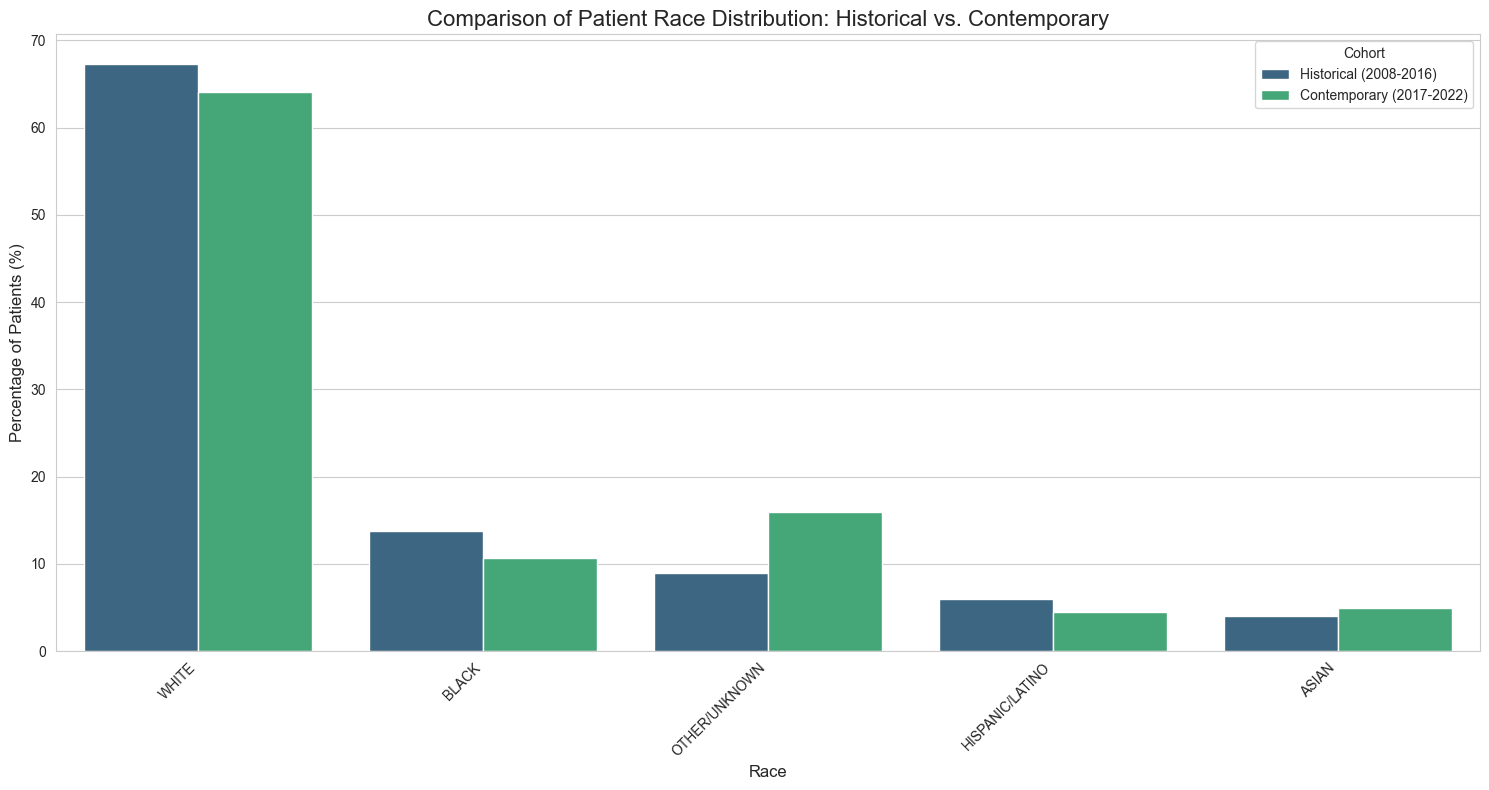

In [31]:
# Calculate the percentage distribution for the historical cohort
historical_race_dist = historical['race_grouped'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
historical_race_dist['Cohort'] = 'Historical (2008-2016)'

# Calculate the percentage distribution for the contemporary cohort
contemporary_race_dist = contemporary['race_grouped'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
contemporary_race_dist['Cohort'] = 'Contemporary (2017-2022)'


combined_race_dist = pd.concat([historical_race_dist, contemporary_race_dist])

# Visualisation 
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

# Create the bar plot
barplot = sns.barplot(data=combined_race_dist, x='race_grouped', y='percentage', hue='Cohort', palette='viridis')

# Add titles and labels
plt.title('Comparison of Patient Race Distribution: Historical vs. Contemporary', fontsize=16)
plt.xlabel('Race', fontsize=12)
plt.ylabel('Percentage of Patients (%)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()

# Save the plot
plt.savefig('race_distribution_comparison.png')